# Import Libraries & Dataset

In [17]:
# Import libraries | Standard
import pandas as pd
import numpy as np
import os
from time import time
import datetime

# Import libraries | Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Import libraries | Sk-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import KFold, cross_val_score

import xgboost as xgb
from lightgbm import LGBMRegressor

# Pretty display for notebooks
%matplotlib inline

In [2]:
def train_predict(learner, sample_size, train_X, train_y, test_X, test_y): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set       
       - train_X: features training set
       - train_y: income training set
       - test_X: features testing set
       - test_y: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(train_X[:sample_size], train_y[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['time_train'] = end - start
        
    # Get the predictions on the test set(X_test),
    start = time() # Get start time
    predictions = learner.predict(test_X)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['time_pred'] = end - start
            
    # Compute Mean Accuracy Error on Test Set
    results['MAE'] = mean_absolute_error(test_y, predictions)
        
    # Compute Mean Squared Error on Test Set
    results['MSE'] = mean_squared_error(test_y, predictions)
    
    # Compute Mean Squared Log Error on Test Set
    #results['MSLE'] = mean_squared_log_error(test_y, predictions)
               
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [3]:
def evaluate(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['time_train', 'time_pred', 'MAE', 'MSE']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    #ax[0, 1].set_ylabel("Accuracy Score")
    #ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("MAE")
    ax[1, 2].set_ylabel("MSE")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    #ax[0, 1].set_title("Accuracy Score on Training Subset")
    #ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("MAE on Testing Set")
    ax[1, 2].set_title("MSE on Testing Set")
 
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [4]:
def feature_plot(importances, train_X, train_y, topk=5):
    
    # Display the most important features
    indices = np.argsort(importances)[::-1]
    columns = train_X.columns.values[indices[:topk]]
    values = importances[indices][:topk]

    # Creat the plot
    fig = plt.figure(figsize = (18,5))
    plt.title("Normalized Weights for First " + str(topk) + " Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(topk), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(topk) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(topk), columns)
    plt.xlim((-0.5, 9.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()  

In [5]:
def reduce_mem_usage(df, verbose=True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

cnt = 0
env = 'AWS'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        cnt += 1
        print(os.path.join(dirname, filename))
        
if cnt > 0:
    env = 'Kaggle'

In [7]:
print('Environment:', env)

Environment: AWS


In [18]:
# Read input files
if env == 'Kaggle':
    features = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv")
    stores = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv")
    train = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv")
    test = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv")
else:    
    features = pd.read_csv("data/features.csv")
    stores = pd.read_csv("data/stores.csv")
    train = pd.read_csv("data/train.csv")
    test = pd.read_csv("data/test.csv")

In [19]:
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Memory usage of dataframe is 13.27 MB
Memory usage after optimization is: 6.03 MB
Decreased by 54.5%
Memory usage of dataframe is 2.74 MB
Memory usage after optimization is: 1.21 MB
Decreased by 56.0%


In [10]:
pd.set_option('display.max_columns', None)  

pd.set_option('display.max_rows', None)

# Data Exploration

### 1. Stores Data

In [11]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [12]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


In [13]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [14]:
#missing data
total = stores.isnull().sum().sort_values(ascending=False)
percent = (stores.isnull().sum()/stores.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Size,0,0.0
Type,0,0.0
Store,0,0.0


### 2. Features Data

In [15]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [16]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 711.9+ KB


In [17]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [18]:
#missing data
total = features.isnull().sum().sort_values(ascending=False)
percent = (features.isnull().sum()/features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
MarkDown2,5269,0.643346
MarkDown4,4726,0.577045
MarkDown3,4577,0.558852
MarkDown1,4158,0.507692
MarkDown5,4140,0.505495
Unemployment,585,0.071429
CPI,585,0.071429
IsHoliday,0,0.000000
Fuel_Price,0,0.000000
Temperature,0,0.000000


In [19]:
# Distribution of NaNs for all columns
features_missing = features.isna().sum()/len(features) * 100

<BarContainer object of 12 artists>

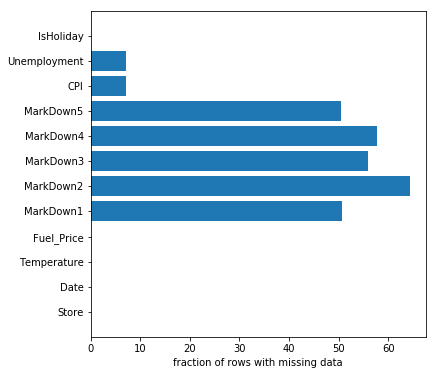

In [20]:
plt.figure(figsize=(6,6))
plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
plt.xlabel('fraction of rows with missing data')
plt.barh(np.arange(len(features_missing)), features_missing)

In [21]:
features['Date'].str.slice(start=0, stop=4).value_counts()

2011    2340
2012    2340
2010    2160
2013    1350
Name: Date, dtype: int64

In [22]:
holidays = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08', #Super Bowl
           '2010-09-10', '2011-09-09', '2012-09-07', '2013-02-06',  #Labor Day
           '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  #Thanksgiving
           '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']  #Christmas

In [23]:
# Validate Holidays
features['IsHoliday'][features['Date'].isin(holidays)].value_counts()

True    585
Name: IsHoliday, dtype: int64

In [24]:
features['Date'][features['IsHoliday'].isin([1])][~features['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

### 3. Train Data

In [25]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.500000,False
1,1,1,2010-02-12,46039.488281,True
2,1,1,2010-02-19,41595.550781,False
3,1,1,2010-02-26,19403.539062,False
4,1,1,2010-03-05,21827.900391,False


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int8
Dept            421570 non-null int8
Date            421570 non-null object
Weekly_Sales    421570 non-null float32
IsHoliday       421570 non-null bool
dtypes: bool(1), float32(1), int8(2), object(1)
memory usage: 6.0+ MB


In [27]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15978.299805
std,12.785297,30.492054,22707.693359
min,1.000000,1.000000,-4988.939941
25%,11.000000,18.000000,2079.649902
50%,22.000000,37.000000,7612.029785
75%,33.000000,74.000000,20205.852051
max,45.000000,99.000000,693099.375000


In [28]:
train['Date'].str.slice(start=0, stop=4).value_counts()

2011    153453
2010    140679
2012    127438
Name: Date, dtype: int64

In [29]:
# Validate Holidays
train['IsHoliday'][train['Date'].isin(holidays)].value_counts()

True    29661
Name: IsHoliday, dtype: int64

In [30]:
train['Date'][train['IsHoliday'].isin([1])][~train['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


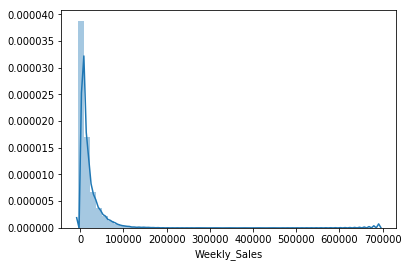

In [31]:
#histogram
sns.distplot(train['Weekly_Sales'])

In [32]:
train['Store'][train['Weekly_Sales'] < 0].sum()

30658

### 4. Test Data

In [33]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
Store        115064 non-null int8
Dept         115064 non-null int8
Date         115064 non-null object
IsHoliday    115064 non-null bool
dtypes: bool(1), int8(2), object(1)
memory usage: 1.2+ MB


In [35]:
test.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


In [36]:
test['Date'].str.slice(start=0, stop=4).value_counts()

2013    88275
2012    26789
Name: Date, dtype: int64

In [37]:
# Validate Holidays
test['IsHoliday'][test['Date'].isin(holidays)].value_counts()

True    8928
Name: IsHoliday, dtype: int64

In [38]:
train['Date'][train['IsHoliday'].isin([1])][~train['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

# Data Pre-Processing

## 1. Fill NaN Values

#### Features dataset has NaN values for multiple columns:

##### Columns: CPI and Unemployment

In [39]:
features['Date'].str.slice(start=0, stop=7)[features['CPI'].isna()].value_counts()

2013-05    225
2013-07    180
2013-06    180
Name: Date, dtype: int64

In [40]:
features['Date'].str.slice(start=0, stop=7)[features['Unemployment'].isna()].value_counts()

2013-05    225
2013-07    180
2013-06    180
Name: Date, dtype: int64

In [41]:
features[['CPI','Unemployment']].groupby([features['Store'], features['Date'].str.slice(start=0, stop=7)]).mean().head(84)

CPI  Unemployment
Store Date                             
1     2010-02  211.236828         8.106
      2010-03  211.241116         8.106
      2010-04  210.552135         7.808
      2010-05  210.547812         7.808
      2010-06  211.356237         7.808
      2010-07  211.207476         7.787
      2010-08  211.578688         7.787
      2010-09  211.536531         7.787
      2010-10  211.800525         7.838
      2010-11  211.899611         7.838
      2010-12  211.457702         7.838
      2011-01  211.721611         7.742
      2011-02  213.071770         7.742
      2011-03  214.224260         7.742
      2011-04  215.258255         7.682
      2011-05  215.749441         7.682
      2011-06  215.101584         7.682
      2011-07  215.345630         7.962
      2011-08  215.638236         7.962
      2011-09  216.157134         7.962
      2011-10  217.398324         7.866
      2011-11  218.130899         7.866
      2011-12  219.149949         7.866
      2012-01  219.917832         7.348
      2012-02  220.374964         7.348
      2012-03  221.153294         7.348
      2012-04  221.531958         7.143
      2012-05  221.721270         7.143
      2012-06  221.781152         7.143
      2012-07  221.920490         6.908
...                   ...           ...
2     2011-02  212.727665         8.028
      2011-03  213.877488         8.028
      2011-04  214.908582         7.931
      2011-05  215.398826         7.931
      2011-06  214.754360         7.931
      2011-07  214.998246         7.852
      2011-08  215.291750         7.852
      2011-09  215.810080         7.852
      2011-10  217.047711         7.441
      2011-11  217.777737         7.441
      2011-12  218.792544         7.441
      2012-01  219.558147         7.057
      2012-02  220.014484         7.057
      2012-03  220.791516         7.057
      2012-04  221.170021         6.891
      2012-05  221.358968         6.891
      2012-06  221.419302         6.891
      2012-07  221.557961         6.565
      2012-08  221.721490         6.565
      2012-09  222.331393         6.565
      2012-10  222.992375         6.170
      2012-11  223.159882         6.170
      2012-12  223.427985         6.170
      2013-01  223.821473         6.237
      2013-02  223.925989         6.237
      2013-03  224.439928         6.237
      2013-04  224.781713         6.112
      2013-05         NaN           NaN
      2013-06         NaN           NaN
      2013-07         NaN           NaN

[84 rows x 2 columns]

In [42]:
%%time
# For each Store, propogate values of CPI & Unemployment to the rows with NaN values
for i in range(len(features)):

    if features.iloc[i]['Date'] == '2013-04-26':
        CPI_new = features.iloc[i]['CPI']
        Unemployment_new = features.iloc[i]['Unemployment']
    
    if np.isnan(features.iloc[i]['CPI']):
        features.iat[i, 9] = CPI_new
        features.iat[i, 10] = Unemployment_new

CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.54 s


##### Columns: MarkDown1, MarkDown2, MarkDown3, MarkDown4 & MarkDown5

In [43]:
features.groupby(features['Date'].str.slice(start=0, stop=7))['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'].count()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Date,,,,,
2010-02,0,0,0,0,0
2010-03,0,0,0,0,0
2010-04,0,0,0,0,0
2010-05,0,0,0,0,0
2010-06,0,0,0,0,0
2010-07,0,0,0,0,0
2010-08,0,0,0,0,0
2010-09,0,0,0,0,0
2010-10,0,0,0,0,0


In [44]:
%%time
# For each date, retrive the corresponding week number
features['Week'] = 0

for i in range(len(features)):
    features.iat[i, 12] = datetime.date(int(features.iloc[i]['Date'][0:4]), 
                                        int(features.iloc[i]['Date'][5:7]), 
                                        int(features.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 3.98 s, sys: 2.04 ms, total: 3.99 s
Wall time: 3.99 s


In [45]:
features['Year'] = features['Date'].str.slice(start=0, stop=4)

In [46]:
features.to_csv('features_new.csv', index=False)

In [47]:
#missing data for 2012 & 2013
total = features[features['Year'].isin(['2012','2013'])].isnull().sum().sort_values(ascending=False)
percent = (features[features['Year'].isin(['2012','2013'])].isnull().sum()/
           features[features['Year'].isin(['2012','2013'])].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(4)

,Total,Percent
MarkDown2,1062,0.287805
MarkDown4,528,0.143089
MarkDown3,419,0.113550
MarkDown1,12,0.003252


In [48]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 14 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             8190 non-null float64
Unemployment    8190 non-null float64
IsHoliday       8190 non-null bool
Week            8190 non-null int64
Year            8190 non-null object
dtypes: bool(1), float64(9), int64(2), object(2)
memory usage: 839.9+ KB


In [49]:
%%time
# For 2010 & 2011 records, for each store, copy over MarkDown values from 2012

# Iterate through stores
for i in range(1, len(features['Store'].unique())):
    
    # For 2010, iterate through weeks 5 thru 52
    for j in range(5, 52):
        idx = features.loc[(features.Year == '2010') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]
        
    # For 2011, iterate through weeks 1 thru 44
    for j in range(1, 44):
        idx = features.loc[(features.Year == '2011') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]        

CPU times: user 1min 5s, sys: 149 ms, total: 1min 5s
Wall time: 1min 5s


In [50]:
# Now fill all the missing MarkDown values with 0
features.fillna(0, inplace=True)

In [51]:
features.drop(columns=['Year'], axis=1, inplace=True)

In [52]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 13 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       8190 non-null float64
MarkDown2       8190 non-null float64
MarkDown3       8190 non-null float64
MarkDown4       8190 non-null float64
MarkDown5       8190 non-null float64
CPI             8190 non-null float64
Unemployment    8190 non-null float64
IsHoliday       8190 non-null bool
Week            8190 non-null int64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 775.9+ KB


In [53]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week
count,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000
mean,23.000000,59.356198,3.405992,6976.320181,1811.670559,1198.804396,2863.165574,4154.038877,172.855800,7.747708,25.214286
std,12.987966,18.678607,0.431337,8858.758992,5976.626074,9529.844233,6230.558437,13118.861737,39.898285,1.878347,14.527604
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,126.064000,3.684000,1.000000
25%,12.000000,45.902500,3.041000,1476.427500,0.000000,2.280000,75.005000,1473.960000,132.653774,6.565000,13.000000
50%,23.000000,60.710000,3.513000,4842.475000,56.000000,15.750000,896.430000,2801.890000,182.855869,7.742000,24.000000
75%,34.000000,73.880000,3.743000,9057.890000,621.840000,81.740000,2936.405000,4895.180000,214.367504,8.549000,37.000000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000,52.000000


In [54]:
train = pd.merge(train, stores, how='left', on=['Store'])
train = pd.merge(train, features, how='left', on=['Store','Date'])

In [55]:
test = pd.merge(test, stores, how='left', on=['Store'])
test = pd.merge(test, features, how='left', on=['Store','Date'])

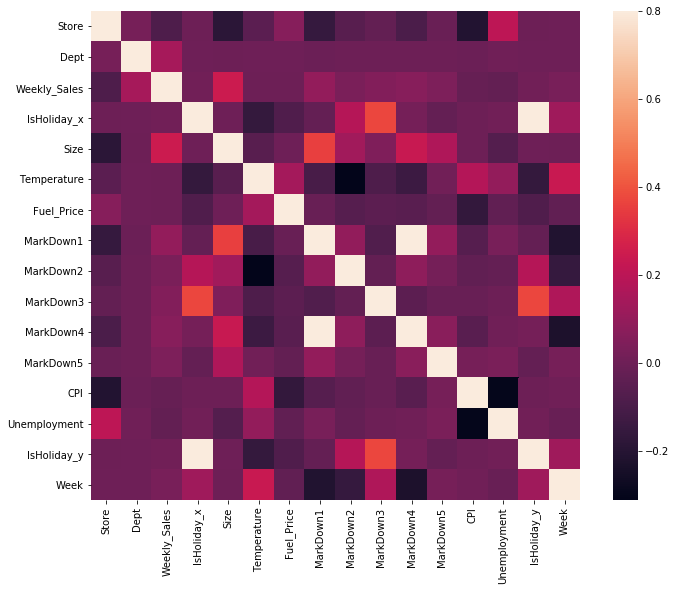

In [56]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

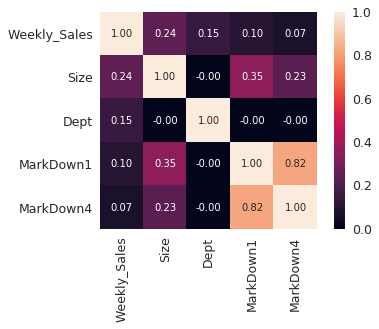

In [57]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Weekly_Sales')['Weekly_Sales'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [58]:
train['Store'][train['IsHoliday_x'] != train['IsHoliday_y']].count()

0

In [59]:
test['Store'][test['IsHoliday_x'] != test['IsHoliday_y']].count()

0

In [60]:
del train['IsHoliday_y']
del test['IsHoliday_y']

In [61]:
train.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
test.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

In [62]:
train['Type'].value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64

In [63]:
test['Type'].value_counts()

A    58713
B    44500
C    11851
Name: Type, dtype: int64

In [64]:
train = pd.get_dummies(train, columns=['Type'])
test = pd.get_dummies(test, columns=['Type'])

In [65]:
train['IsHoliday'] = train['IsHoliday'].apply(lambda x: 1 if x==True else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x==True else 0)

In [66]:
train['Week'] = test['Week'] = 0

In [67]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(train)):
    train.iat[i, 15] = datetime.date(int(train.iloc[i]['Date'][0:4]), 
                                     int(train.iloc[i]['Date'][5:7]), 
                                     int(train.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 3min 57s, sys: 12.3 ms, total: 3min 57s
Wall time: 3min 57s


In [68]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(test)):
    test.iat[i, 14] = datetime.date(int(test.iloc[i]['Date'][0:4]), 
                                    int(test.iloc[i]['Date'][5:7]), 
                                    int(test.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 1min 4s, sys: 7.96 ms, total: 1min 4s
Wall time: 1min 4s


#train['Year'] = train['Date'].str.slice(start=0, stop=4)
train['Month'] = train['Date'].str.slice(start=5, stop=7)

#test['Year'] = test['Date'].str.slice(start=0, stop=4)
test['Month'] = test['Date'].str.slice(start=5, stop=7)

In [69]:
submission = test[['Store', 'Dept', 'Date']].copy()

In [70]:
submission['Id'] = submission['Store'].map(str) + '_' + submission['Dept'].map(str) + '_' + submission['Date'].map(str)

In [71]:
submission.drop(['Store', 'Dept', 'Date'], axis=1, inplace=True)

train.drop(columns=['Date','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1, inplace=True)
test.drop(columns=['Date','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1, inplace=True)

In [72]:
train.drop(columns=['Date'], axis=1, inplace=True)
test.drop(columns=['Date'], axis=1, inplace=True)

In [73]:
train.drop(columns=['MarkDown1'], axis=1, inplace=True)
test.drop(columns=['MarkDown1'], axis=1, inplace=True)

In [74]:
len(train), len(test)

(421570, 115064)

In [75]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
#numerical = ['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
numerical = ['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
             'MarkDown2','MarkDown3','MarkDown4','MarkDown5']

train_scaled = pd.DataFrame(data = train)
train_scaled[numerical] = scaler.fit_transform(train[numerical])

# Show an example of a record with scaling applied
display(train_scaled.head(n = 5))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C
0,1,1,24924.500000,0,0.630267,0.434149,0.050100,0.036694,0.001268,0.480236,0.007346,0.840500,0.405118,5,1,0,0
1,1,1,46039.488281,1,0.630267,0.396967,0.038076,0.068645,0.000874,0.125556,0.008974,0.841941,0.405118,6,1,0,0
2,1,1,41595.550781,0,0.630267,0.410861,0.021042,0.108107,0.000260,0.124629,0.004459,0.842405,0.405118,7,1,0,0
3,1,1,19403.539062,0,0.630267,0.476419,0.044589,0.074646,0.000216,0.018080,0.010604,0.842707,0.405118,8,1,0,0
4,1,1,21827.900391,0,0.630267,0.475147,0.076653,0.017510,0.000267,0.376301,0.010505,0.843008,0.405118,9,1,0,0


In [76]:
test_scaled = pd.DataFrame(data = test)
test_scaled[numerical] = scaler.fit_transform(test[numerical])

# Show an example of a record with scaling applied
display(test_scaled.head(n = 5))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C
0,1,1,0,0.630267,0.573142,0.410215,0.072893,0.001537,0.055703,0.003788,0.943588,0.443438,44,1,0,0
1,1,1,0,0.630267,0.627334,0.352753,0.047907,0.001467,0.071112,0.008215,0.943778,0.443438,45,1,0,0
2,1,1,0,0.630267,0.551172,0.303272,0.004610,0.001891,0.017341,0.008810,0.944101,0.443438,46,1,0,0
3,1,1,1,0.630267,0.581472,0.270551,0.000561,0.501726,0.003212,0.000633,0.944603,0.443438,47,1,0,0
4,1,1,0,0.630267,0.545862,0.267358,0.000503,0.026844,0.002304,0.009268,0.945105,0.443438,48,1,0,0


In [77]:
train = test = features = stores = None

In [78]:
train_scaled.to_csv('train_scaled.csv', index=False)
test_scaled.to_csv('test_scaled.csv', index=False)

In [9]:
train_scaled = pd.read_csv("train_scaled.csv")
test_scaled = pd.read_csv("test_scaled.csv")

In [10]:
weekly_sales = train_scaled['Weekly_Sales']
train_scaled = train_scaled.drop('Weekly_Sales', axis = 1)

In [11]:
train_X, val_X, train_y, val_y = train_test_split(train_scaled, weekly_sales, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(train_X.shape[0]))
print("Validation set has {} samples.".format(val_X.shape[0]))

Training set has 337256 samples.
Validation set has 84314 samples.


In [12]:
train_scaled = weekly_sales = None

In [13]:
train_X.shape,val_X.shape, test_scaled.shape

((337256, 16), (84314, 16), (115064, 16))

In [14]:
train_X=reduce_mem_usage(train_X)
val_X=reduce_mem_usage(val_X)
test_scaled=reduce_mem_usage(test_scaled)
submission=reduce_mem_usage(submission)

Memory usage of dataframe is 43.74 MB
Memory usage after optimization is: 10.61 MB
Decreased by 75.7%
Memory usage of dataframe is 10.94 MB
Memory usage after optimization is: 2.65 MB
Decreased by 75.7%
Memory usage of dataframe is 14.05 MB
Memory usage after optimization is: 2.74 MB
Decreased by 80.5%


NameError: name 'submission' is not defined

In [85]:
# This is our local data directory. We need to make sure that it exists.
data_dir = 'input'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

%%time
# Try different numbers of n_estimators - this will take a minute or so
model = RandomForestRegressor(random_state=42)
estimators = np.arange(25, 125, 25)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(train_X, train_y)
    print(n)
    print(model.score(train_X, train_y))
    scores.append(model.score(train_X, train_y))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [86]:
#Extract the feature importances
importances = model.feature_importances_

# Plot
feature_plot(importances, train_X, train_y, 10)

NameError: name 'model' is not defined

In [ ]:
topk = 17
indices = np.argsort(importances)[::-1]
columns = train_X.columns.values[indices[:topk]]
values = importances[indices][:topk]

for i in range(topk):
    print(columns[i] + '\t: ' + str(values[i]))

train_X.drop(columns=['Year_2010','Year_2011','Year_2012','Year_2013'], axis=1, inplace=True)
val_X.drop(columns=['Year_2010','Year_2011','Year_2012','Year_2013'], axis=1, inplace=True)
test_scaled.drop(columns=['Year_2010','Year_2011','Year_2012','Year_2013'], axis=1, inplace=True)

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_X, train_y)
pred_y = tree_reg.predict(val_X)
tree_mse = mean_squared_error(val_y, pred_y)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

In [44]:
%%time
from sklearn.ensemble import RandomForestRegressor

#model = RandomForestRegressor(random_state=42, n_estimators=100)
model = RandomForestRegressor(random_state=42, n_estimators=25, criterion='mae')

CPU times: user 91 µs, sys: 0 ns, total: 91 µs
Wall time: 98.9 µs


In [ ]:
%%time
model.fit(train_X, train_y)
pred_y = model.predict(val_X)
forest_mse = mean_squared_error(val_y, pred_y)
forest_rmse = np.sqrt(forest_mse)

In [1]:
forest_rmse

NameError: name 'forest_rmse' is not defined

In [ ]:
pred_y = model.predict(test_scaled)

In [ ]:
submission['Weekly_Sales'] = pred_y

In [ ]:
submission[['Id','Weekly_Sales']].to_csv('submission.csv', index=False)

In [ ]:
submission[['Id','Weekly_Sales']].to_csv(data_dir + '/submission.csv', index=False)

In [ ]:
val_X['IsHoliday']

In [1]:
train_X

NameError: name 'train_X' is not defined

In [22]:
weekly_sales = None

In [20]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('train_X', 11129472),
 ('train_y', 5396120),
 ('weekly_sales', 3372664),
 ('test_scaled', 2876704),
 ('val_X', 2782386),
 ('val_y', 1349048),
 ('ARDRegression', 1464),
 ('BaggingRegressor', 1464),
 ('DecisionTreeRegressor', 1464),
 ('MinMaxScaler', 1056),
 ('RandomForestRegressor', 1056),
 ('evaluate', 136),
 ('feature_plot', 136),
 ('mean_absolute_error', 136),
 ('mean_squared_error', 136),
 ('mean_squared_log_error', 136),
 ('reduce_mem_usage', 136),
 ('train_predict', 136),
 ('train_test_split', 136),
 ('mpatches', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('regr', 56),
 ('bag_mse', 32),
 ('bag_rmse', 32),
 ('pred_y_bag', 16),
 ('train_scaled', 16)]

In [ ]:
# Initialize the models
clf_A = DecisionTreeRegressor(random_state=42)
clf_B = RandomForestRegressor(random_state=42, n_estimators=100)
#clf_C = AdaBoostClassifier(random_state=1)

samples_100 = len(train_y)              # 100% of training set
samples_10 = int(samples_100 * 10/100)  #  10% of training set
samples_1 = int(samples_100 * 1/100)    #   1% of training set

# Collect results on the learners
results = {}
#for clf in [clf_A, clf_B, clf_C]:
for clf in [clf_A, clf_B]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, train_X, train_y, val_X, val_y)

# Run metrics visualization for the three supervised learning models chosen
#vs.evaluate(results, accuracy, fscore)

In [ ]:
print(results)

In [ ]:
evaluate(results)

## Ensemble | Gradient Boosting

In [100]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)  

In [101]:
%%time
gbr.fit(train_X, train_y)

CPU times: user 15min 41s, sys: 87.8 ms, total: 15min 41s
Wall time: 15min 42s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [102]:
pred_y_gbr = gbr.predict(val_X)
gbr_mse = mean_squared_error(val_y, pred_y_gbr)
gbr_rmse = np.sqrt(gbr_mse)
print("GBR score on training set: ", gbr_rmse)
pred_y_gbr = None

GBR score on training set:  8387.480421601318


CPU times: user 15min 41s, sys: 87.8 ms, total: 15min 41s
Wall time: 15min 42s

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

GBR score on training set:  8387.480421601318

## Ensemble | BaggingRegressor

In [14]:
regr = BaggingRegressor(random_state=0, n_estimators=100)

In [15]:
%%time
regr.fit(train_X, train_y)

CPU times: user 5min 31s, sys: 1.44 s, total: 5min 32s
Wall time: 5min 32s


BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=None, oob_score=False, random_state=0,
         verbose=0, warm_start=False)

In [17]:
pred_y_bag = regr.predict(val_X)
bag_mse = mean_squared_error(val_y, pred_y_bag)
bag_rmse = np.sqrt(bag_mse)
print("Bagging score on training set: ", bag_rmse)
pred_y_bag = None

Bagging score on training set:  3382.6887076620246


CPU times: user 5min 31s, sys: 1.44 s, total: 5min 32s
Wall time: 5min 32s
BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=None, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
         
Bagging score on training set:  3382.6887076620246


## XGB

In [19]:
model = xgb.XGBRegressor()

In [20]:
# Add silent=True to avoid printing out updates with each cycle
model.fit(train_X, train_y, verbose=False)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:27:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [21]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
pred_y = None

Mean Swuared Error:  11309.706774161677
Mean Absolute Error: 6858.918969562958


In [25]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05)
model.fit(train_X, train_y, early_stopping_rounds=5, 
          eval_set=[(val_X, val_y)], verbose=False)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:28:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [26]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
pred_y = None

Mean Swuared Error:  13259.447391173178
Mean Absolute Error: 8299.89861409434


In [30]:
model = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

In [ ]:
model.fit(train_X, train_y)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.2, gamma=0.0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=1.5, missing=None, n_estimators=7200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.9, reg_lambda=0.6, scale_pos_weight=1, seed=42,
       silent=1, subsample=0.2, verbosity=1)

In [ ]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
pred_y = None

Mean Swuared Error:  9439.0743962953
Mean Absolute Error: 5639.002595414038


In [ ]:
XGB = xgb.XGBRegressor(max_depth=3,learning_rate=0.1,n_estimators=1000,reg_alpha=0.001,reg_lambda=0.000001,n_jobs=-1,min_child_weight=3)
XGB.fit(train_X,train_y)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
pred_y = None

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_y)
dtest = xgb.DMatrix(val_X)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(train_X, train_y)

xgb_preds = np.expm1(model_xgb.predict(val_X))

In [ ]:
xgb_mse = mean_squared_error(val_y, pred_y)
xgb_rmse = np.sqrt(xgb_mse)
print("XGBoost score on training set: ", xgb_rmse)

In [ ]:
print("Mean Absolute Error : " + str(mean_absolute_error(xgb_preds, val_y)))

In [ ]:
from sklearn.linear_model import Lasso

# I found this best alpha through cross-validation.
best_alpha = 0.0099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(train_X, train_y)

In [ ]:
pred_y_lasso = regr.predict(val_X)
lasso_mse = mean_squared_error(val_y, pred_y_lasso)
lasso_rmse = np.sqrt(lasso_mse)
print("Lasso score on training set: ", lasso_rmse)

In [ ]:
# Blend the results of the two regressors and save the prediction to a CSV file.

pred_y = (pred_y_xgb + y_pred_lasso) / 2
#pred_y = np.exp(pred_y)

In [ ]:
blended_mse = mean_squared_error(val_y, pred_y)
blended_rmse = np.sqrt(blended_mse)
print("Blended score on training set: ", blended_rmse)

In [ ]:
pred_df = pd.DataFrame(pred_y, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('submission.csv', header=True, index_label='Id')

## LGBM

In [ ]:
model = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [28]:
model.fit(train_X, train_y)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [29]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
print("Mean Swuared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
pred_y = None

Mean Swuared Error:  13259.447391173178
Mean Absolute Error: 8299.89861409434


test_scaled.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([val_y, val_X], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([train_y, train_X], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

prefix = 'boston-xgboost-tuning-HL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

prefix = 'walmart-store-sales'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

xgb_hyperparameter_tuner.wait()

xgb_hyperparameter_tuner.best_training_job()

xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

xgb_transformer.wait()

!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

plt.scatter(test_y, pred_y)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")